# Text Classification:  Insults with Naive Bayes

In [210]:
import numpy as np
import pandas as pd
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV as gs
import sklearn.feature_extraction.text as text
import sklearn.naive_bayes as nb
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score

## Loading and preparing the data

Let's open the CSV file with `pandas`.

In [57]:
import os.path
site = 'https://raw.githubusercontent.com/gawron/python-for-social-science/master/'\
'text_classification/'
#site = 'https://gawron.sdsu.edu/python_for_ss/course_core/book_draft/_static/'
df = pd.read_csv(os.path.join(site,"troll.csv"))

Each row is a comment  taken from a blog or online forum. There are three columns: whether the comment is insulting (1) or not (0), the data, and the unicode-encoded contents of the comment.

In [59]:
df[['Insult', 'Comment']].tail()

,Insult,Comment
3942,1,"""you are both morons and that is never happening"""
3943,0,"""Many toolbars include spell check, like Yahoo..."
3944,0,"""@LambeauOrWrigley\xa0\xa0@K.Moss\xa0\nSioux F..."
3945,0,"""How about Felix? He is sure turning into one ..."
3946,0,"""You're all upset, defending this hipster band..."


Write a pandas command to create a DataFrame containing just the insults.

In [5]:
# Solution replaces df on the RHS
insult_df = df[df['Insult'] ==1].copy()

In [55]:
insult_df[:25]

,Insult,Date,Comment,Size
0,1,20120618192155Z,"""You fuck your dad.""",20
7,1,NaN,"""shut the fuck up. you and the rest of your fa...",89
8,1,20120502173553Z,"""Either you are fake or extremely stupid...may...",57
9,1,20120620160512Z,"""That you are an idiot who understands neither...",76
15,1,20120611090207Z,"""FOR SOME REASON U SOUND RETARDED. LOL. DAMN. ...",65
16,1,20120320162532Z,"""You with the 'racist' screen name\n\nYou are ...",70
18,1,20120320075347Z,"""your such a dickhead...""",25
19,1,20120320203947Z,"""Your a retard go post your head up your #%&*""",46
34,1,20120515132156Z,"""Allinit123, your\xa0hypocrisy\xa0is sickening...",68
37,1,20120620161958Z,"""I can't believe the stupid people on this sit...",237


Write a line of code to compute what proportion of the data classified as an Insul

In [6]:
len(insult_df)

1049

In [7]:
len(df)

3947

In [8]:
df['Insult'].sum()/df.shape[0]

0.2657714720040537

There are documents of a **variety** of lengths, from various kinds of social media.  From pretty long...

In [9]:
df['Comment'][79]

'"Fact : Georgia passed a strict immigration policy and most of the Latino farm workers left the area. Vidalia Georgia now has over 3000 agriculture job openings and they have been able to fill about 250 of them in past year. All you White Real Americans who are looking for work that the Latinos stole from you..Where are you ? The jobs are i Vadalia just waiting for you..Or maybe its the fact that you would rather collect unemployment like the rest of the Tea Klaners.. You scream..you complain..and you sit at home in your wife beaters and drink beer..Typical Real White Tea Klan...."'

To very very short:

In [10]:
insult_df.loc[755]

Insult                   1
Date       20120620121441Z
Comment           "Retard"
Name: 755, dtype: object

A look at the range.  Some very long documents have to processed and
correctly taggeda s insulting.  This is part of the challenge of this dataset.

In [11]:
insult_df["Comment"].str.len()

0         20
7         89
8         57
9         76
15        65
        ... 
3929     303
3931    1600
3934     334
3935      89
3942      49
Name: Comment, Length: 1049, dtype: int64

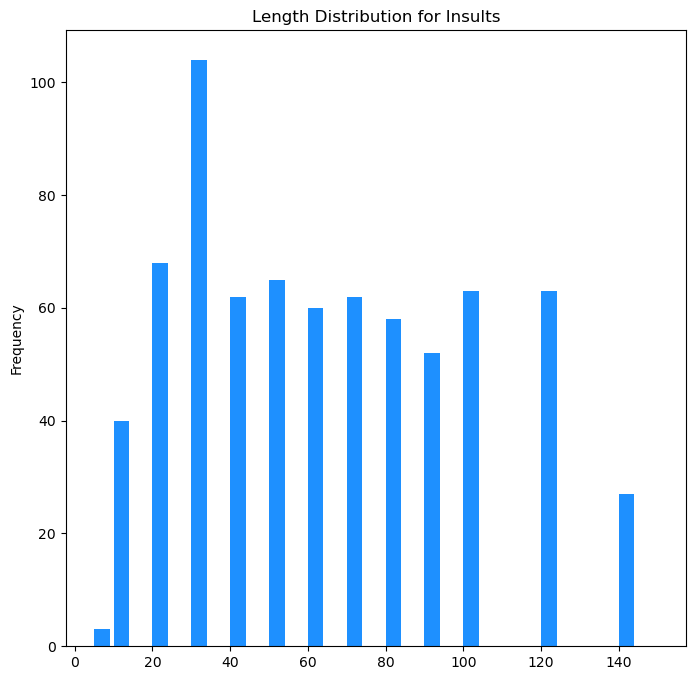

In [12]:
from matplotlib import pyplot as plt
(fig, ax) = plt.subplots(1,1,figsize=(8,8))
insult_df["Size"] = insult_df["Comment"].str.len()

bar = insult_df["Size"].plot(kind="hist",bins=[5, 10, 20, 30,40, 50,60,
                                         70, 80, 90, 100, 120,140, 150], width=4,color="dodgerblue",
                          title="Length Distribution for Insults")

## Analyzing insults with Naive Bayes: sklearn

We want to use one of the linear classifiers in `sklearn`,
but the learners in `sklearn` only work with 2D numerical arrays.
We next discuss how to convert text into an array  of numbers.

Given a collection of documents of size D and some class labels L,
the classical solution can be described in several steps:

1. extract a **vocabulary** of size V by scanning all the texts in . Then, we build a DxV **term-document matrix** `M`.
2. For each document `d` and each word `w` fill cell `[d,w]` of `M` with a number representing the importance of word `w` in document `d`, in the simplest case, its count.  Thus one row of M represents one document in the collection. Since most documents contain only a small portion of the total vocabulary of the document collection, M is almost always **sparse**; that is, it consists almost entirely of zeros.
3. Train a classifer on the term document matrix M and class labels L.

The `sklearn` module allows us to
complete steps 1 and 2 in a few lines of code using what is called a **vectorizer**.  Step
3 is another few lines of code using a scikit learn  **classifier**. Although
there are a few things to watch out for, the same classifiers that work for other classification
problems generally work for text classification.

We first encountered a scikit learn vectorizer in the regression and classification
notebook in building an adjective classifier.  There, we were classifying words, not documents.
and the features used for classification were letter sequences from 2 to 4 characters long;
the feature values were counts of how many times a given letter sequence occurred in the word.
The Count Vectorizer learned 78,696  features, so in
the training data matrix, each word in the training data was rrepsented as
a row (or **vector**) of 78, 696 integers, most of them zero.

For example, the nonzero feature counts for the word "alfalfa" looked like this


```python
' a'  : 1
' al' : 1
' alf': 1
'a '  : 1
'al'  : 2
'alf' : 2
'alfa': 2
'fal' : 1
'fa'  : 2
'fa ' : 1
'falf': 1
'lfa' : 2
'lf'  : 2
'lfa ': 1
'lfal': 1
```

Based on these feature counts
the classifier computed a probability that a word was an adjective.
Although a vectorizer that measures the importance of a word
by its count is always feasible, it doesn't work as well as you might think
when the features are words.  Words counts are not very reliable
indicators of the importance of a word because the most frequent
words (*the*, *of*, *a*) tell us nothing about what a document is about.

To represent the importance of a word in a document,  we will use a **TFIDF score**.
Although there are a number of metric that has had success  inNatural Language Processing tasks; the
TFIDF score has consistently been one of the more successful, and scikit_learn
provides an implmenetation through its `TfidfVectorizer`.

In [13]:
print(text.TfidfVectorizer.__doc__)

Convert a collection of raw documents to a matrix of TF-IDF features.

    Equivalent to :class:`CountVectorizer` followed by
    :class:`TfidfTransformer`.

    Read more in the :ref:`User Guide <text_feature_extraction>`.

    Parameters
    ----------
    input : {'filename', 'file', 'content'}, default='content'
        - If `'filename'`, the sequence passed as an argument to fit is
          expected to be a list of filenames that need reading to fetch
          the raw content to analyze.

        - If `'file'`, the sequence items must have a 'read' method (file-like
          object) that is called to fetch the bytes in memory.

        - If `'content'`, the input is expected to be a sequence of items that
          can be of type string or byte.

    encoding : str, default='utf-8'
        If bytes or files are given to analyze, this encoding is used to
        decode.

    decode_error : {'strict', 'ignore', 'replace'}, default='strict'
        Instruction on what to do if a b

Let's try this idea out on a very small data set:

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = [
        'This is the first document.',
         'This document is the second document.',
         'And this is the third one.',
         'Is this the first document?',
    ]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
feats = vectorizer.get_feature_names_out()
print(len(feats))
print(feats)

9
['and' 'document' 'first' 'is' 'one' 'second' 'the' 'third' 'this']


So the vocabulary size is 9, so assuming this is  all the training data,
the document vectors of any future documents will be represented as vectors
of length 9.

Here is the output of `.fit_transform(...)` , a 4 x 9  term document matrix,
where 4 is the number of documents and 9 is the vocabulary size.

In [62]:
print(X.shape)
X.toarray()

(4, 9)


array([[0.        , 0.46979139, 0.58028582, 0.38408524, 0.        ,
        0.        , 0.38408524, 0.        , 0.38408524],
       [0.        , 0.6876236 , 0.        , 0.28108867, 0.        ,
        0.53864762, 0.28108867, 0.        , 0.28108867],
       [0.51184851, 0.        , 0.        , 0.26710379, 0.51184851,
        0.        , 0.26710379, 0.51184851, 0.26710379],
       [0.        , 0.46979139, 0.58028582, 0.38408524, 0.        ,
        0.        , 0.38408524, 0.        , 0.38408524]])

For each document and word the numerical value is a TFIDF score indicating the weigh/importance
of that word in that document.  In many cases that importance is 0,
indicating that word did not occur in that document.

####  Explaining TFIDF

Here are some statistics from the **British National Corpus**:

```
BNC

Corpus size   51,994,153
 Vocab size      511,928
   Num docs        1,726
```

And here are some interesting cases where word frequency
is close and document frequency  isn't:

```
social                                             18,419          1,083         
want                                               18,284          1,415         

allow                                               5,285          1,232*
computer                                            5,262            715
treatment                                           5,250            906
gives                                               5,258          1,191*
easily                                              5,218          1,212*
```

What we're seeing is that certain words are **burstier** than others.  Once
they occur once in a document, they are much more likely to occur
again in that same document than you'd expect given their frequency.  Take, for example,
*computer*.  Once you see this word, it's likely
that the document it occurs in has something to say about
some technical or computer-related topic, and
so the chances of seeing the word again are high.
On the other hand, consider the word *gives*, whose overall
frequency is nearly the same as *computer*.  This word
doesn't tell you nearly as much about the topic of the document
we're looking at, and the chances of seeing it again in the same document
are neither higher nor lower than you'd expect for
a word of that frequency: *computer* is bursty (it's 5K occurences are distributed
over relatively few documents); *gives* is not.

The TFIDF statistic takes into account not just the relative frequency of a word
in a document (the **Term Frequency**). It also takes into account its burstiness.  Burstiness is measured by **Inverse Document Frequency**.

The term frequency of a term in a document is just its **relative frequency** (frequency
divided by document size).  That depends on both the word and the document


$$
(1) \; \text{tf}(t,d) = \frac{f_{t,d}}{\mid d \mid}
$$


The inverse document frquency of a term $t$ in a set of documents D
is the inverse of its relative frequency in D:

$$
(2) \; \text{idf}(t, D) = \frac{\mid D \mid}{\mid\lbrace d \mid d \in \text{D} \text{ and } t \in d  \rbrace\mid}
$$

This metric depends on the  word and document **set**.

$$
\begin{array}[t]{ll}
\text{D}   & \text{the set of  documents in the training data}\\
\mid\text{D}\mid   & \text{ the number of docs in D}\\
t          & \text{the term or word}\\
\mid\lbrace d \mid d \in \text{D} \text{ and } t \in d  \rbrace\mid &
\text{the number of documents } t \text{ occurs in }\\
\end{array}
$$

Often, instead of using IDF, what's used is the logarithm of IDF:

$$
(3) \; \text{log-idf}(t,\text{D})  = \log (\text{idf}(t, \text{D}))
$$

The expression $\log \text{idf}(t, D)$ is $- \log \text{prob}_{D}(t)$,
which in information theory is the amount of the information
gained by knowing $t$ occurs in a document in the corpus.  So TFIDF
weights the term frequency by the information value of the term.


A very popular version of TFIDF is the product of
the log inverse document frequency and the term count.

$$
(4)\; \text{TFIDF}(t,d)  = \text{tf}(t,d)  \cdot \text{log-idf}(t, D)
$$

Just weight the term frequency of $t$ in $d$ by the information value of $t$.

The version of TFIDF used in scikit learn (also popoular) is esentially the product of
the log inverse document frequency and the term count.

$$
(5)\; \text{TFIDF}(t,d)  = f_{t,d} \cdot \text{log-idf}(t, D)
$$

The raw term frequency is often used rather than the relative frequency
because the document vectors are going to be normalized to
unit length, so the document size will  be taken into
account, but in a slightly different way.


There are some technical details of the scikit learn implementation
discussed [here](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
left out of equation (5), but that's the essential idea.


Let's finish with an example.  Suppose we have a document in which
the word *given* and the word *computer* both occur 3 times.  Let's
use equation (5) and the statistics above to compute the 2 TFIDF scores:

$$
\begin{array}[t]{ll}
(a)\; \text{TFIDF}(\text{computer},d)  &=
\begin{array}[t]{l}
3 \cdot \text{log-idf}(\text{computer}, D)\\
\log \frac{1726}{715}\\
2.64\\
\end{array}\\
(b)\; \text{TFIDF}(\text{gives},d)  & =
\begin{array}[t]{l}
3 \cdot \text{log-idf}(\text{gives}, D)\\
\log \frac{1726}{1191}\\
1.11
\end{array}
\end{array}
$$


So as desired the occurrence of *computer* is more significant, in fact more than twice
as significant.

### Working through the insult data

Having talked through what scikit learn is going to do,  let's get back to
the insult data and demonstrate it.

In [63]:
# Split the data into training and test sets FIRST
T_train,T_test, y_train,y_test = train_test_split(df['Comment'],df['Insult'])

In [64]:
#tf = text.TfidfVectorizer(min_df=2,max_df=.8)
tf = text.TfidfVectorizer()
# Train your vectorizer oNLY on the trainingh data.
X_train = tf.fit_transform(T_train)

`X-train` is our **term-document** matrix.

In [33]:
X_train.shape

(2960, 13586)

The number of columns is over 10,000.  That means our vcabulary size is over 10,000.  The actual vocabulary size of the data is a little larger, because not all of the word in the training set are being used as features.  We'll skip over the details of how those decisions are made.  For now, let's get tp the main idea.

The most important computational fact about the term-document matrix is its sparseness,
the fact that it consists mostly of 0s, because,
for any given document, most of the words in the 10,000 word vocabulary don't occur in it.

In [34]:
# Shape and Number of non zero entries
print(f'Shape: ({X_train.shape[0]:,} x {X_train.shape[1]:,})  Non-zero entries: {X_train.nnz:,}')

Shape: (2,960 x 13,586)  Non-zero entries: 74,539


Let's estimate the sparsity of this feature matrix.

In [35]:
print(("The document matrix X is ~{0:.2%} non-zero features.".format(
          X_train.nnz / float(X_train.shape[0] * X_train.shape[1]))))

The document matrix X is ~0.19% non-zero features.


In [36]:
X_train

<2960x13586 sparse matrix of type '<class 'numpy.float64'>'
	with 74539 stored elements in Compressed Sparse Row format>

The `sklearn` module stores many of its internally computed arrays as **sparse matrices**.  This is basically a
very clever computer science device for not wasting all the space that very sparse matrices
waste.  Natural language representations are often **quite** sparse.  The .15% non zero features
firgure we just looked at was typical.  Sparse matrices come at a cost, however; although some
computations can be done while the matrix is in sparse form, some cannot, and to do those
you have to convert the matrix to a nonsparse matrix, do what you need to do, and then, probably,
convert it back.  This is costly.  We're going to do it now, but only because we're goofing
around. Conversion to non-sparse format should in general be avoided whenever possible.

In [37]:
# Sparse matrix rep => ordinary 2D numpy array/
XA = X_train.toarray()

The number of the column that represents a word in the term document matrix is called its **encoding**.

A `TdidfVectorizer` instance stores its encoding dictionary in the attribute `vocabulary_` (note
the trailing underscore!).

Let's consider the insult word *moron*.

In [38]:
moron_ind = tf.vocabulary_['moron']
moron_ind

7226

Let's find a comment that contains 'moron' and remember its
positional index in the training data so we can look up that doc in X_train.

In [65]:
results = [(i,comment) for (i,comment) in enumerate(T_train) if 'moron' in comment]

#for (i,comment) in enumerate(T_train):
#   if 'moron' in comment:
#        results.append((i,comment))

morons_comments = [(i,comment) for (i,comment) in results if 'morons' in comment]
moron_comment = morons_comments[0][1]
moron_comment_idx = morons_comments[0][0]
doc_i = T_train.iloc[moron_comment_idx]
print(doc_i)

"All racists like you are morons, dude! \n\nIt just happens most pit bull owners are morons too & this has even more convinced me of that."


Ok, now we can check the TFIDF matrix for the statistic for `'moron'` in this document:

In [40]:
XA[moron_comment_idx][moron_ind]

0.0

Wait!  That didn't work! That zero means the word *moron* doesn't occur in this document.

If you go back and look carefully at the last line in this document, the word is actually *morons*, not *moron*, and the  code for choosing a comment from among the `moron_comments` actually guaranteed that.

Since our test for *moron*-documents was to use `in` directly on the document string,
it didn't distinguish occurrences of *moron* from occurrences of *morons*;
`"moron"` is a substring of both words:

```python
>>> "moron" in "you morons!"
True
```

And of course "morons" is a totally different word from *moron*, found at a totally different place in `XA`:

In [41]:
new_moron_ind = tf.vocabulary_['morons']

In [42]:
XA[moron_comment_idx][new_moron_ind]

0.5065367409808235

The moral is that the first preprocessing step in the vectorization process is to break
a document string into a sequence of words.  This step is called **tokenization** and
it's a little more sophisticated than calling `.split()` on the document string,
but the result is similar. The bottom line is that unless you do something
special to change things, the basic units of analysis for a document in text classification
are going to be words, not subsequences of characters as they were in our adjective example.

Summary: In this part of the discussion, we have learned about **vectorization**, the computational
process of going from a sequence of documents to a term-document matrix.

The key point is that the term document matrix is now exactly the sort of thing we used to
train classifier to recognize iris types: a matrix whose rows represent exemplars
and whose columns represent features.  That mean we can just pass the
term document matrix X_train (along with some labels) to a classifier instance to
train it.

## Training

Now, we are going to train a classifier as usual. We
have already split the data and labels into train and test sets.

We use a **Bernoulli Naive Bayes classifier**.

In [43]:
bnb =nb.BernoulliNB()

bnb.fit(X_train, y_train)

BernoulliNB()

And we're done.  How'd we do?  Now we  test on the test set.  Before we can do that we need to
vectorize the test set.  But don't just copy what we did with the training data:

```
X_test = tf.fit_transform(T_test)
```

That would retrain the vectorizer from scratch.  Any words that occurred in the training texts
but not in the test texts would be forgotten!  Plus training the vectorizer
is part of the classifier training pipeline.  If we let the vectorizer see
the test data during its training phase, we'd be compromising the whole
idea of splitting training and test data.  So what we want to do
with the test data is just apply the transform part of vectorizing:

```
X_test = tf.transform(T_test)
```

That is, build a representation of the test data using only the vocabulary you learned
about in training.  Ignore any new words.

In [44]:
X_test = tf.transform(T_test)
bnb.score(X_test, y_test)

0.7527862208713273

### Summarizing everything up till now

Let's summarize what we did by gathering the steps into one cell without all the discussion and re-executing it:

In [45]:
T_train,T_test, y_train,y_test = train_test_split(df['Comment'],df['Insult'])
tf = text.TfidfVectorizer()
X_train = tf.fit_transform(T_train)
bnb =nb.BernoulliNB()
bnb.fit(X_train, y_train)
X_test = tf.transform(T_test)
bnb.score(X_test, y_test)

0.7426545086119554

The result should be the same as when we stepped through it with lots of discussion, right?

Well, is it?  

Ok, re-execute the same cell above again.  Now one more time.

Now try the following
piece of code, which wraps our classification pipeline into
a function.

#### Basic train and test loop

In [46]:
def split_vectorize_and_fit(docs,labels,clf,**params):
    """
    Given labeled data (docs, labels) and a classifier,
    do the training test split.  Train the vectorizer and the classifier.
    Transform the test data and return a set of preducted labels
    for the test data,
    """
    T_train,T_test, y_train,y_test = train_test_split(docs,labels)
    tf = text.TfidfVectorizer(**params)
    X_train = tf.fit_transform(T_train)
    clf_inst = clf()
    clf_inst.fit(X_train, y_train)
    X_test = tf.transform(T_test)
    return clf_inst.predict(X_test), y_test

In [47]:
num_runs = 10
for test_run in range(num_runs):
    predicted, actual = split_vectorize_and_fit(df['Comment'],df['Insult'], nb.BernoulliNB)
    print('{0:.3f}'.format(accuracy_score(predicted, actual)))

0.751
0.773
0.752
0.769
0.754
0.751
0.752
0.751
0.761
0.764


What's happening?  

The training test split function takes a random sample of all the data to use as training data.
Each time there's a train test split we train a slightly different classifier.  Sometimes the
training data is a better preparation for the test than others.   And so the actual
variation in performance is significant.

How should we deal this with this when we report our evaluations?
To report a realistic estimate of how good a classifier our classifier is,
we need to take the average of multiple training runs, each with a different train/test split of our working
data set.

### Refined train and test loop

Explain the purpose of the code in the next cell.

In [48]:
num_runs = 100

stats = np.zeros((4,))
for test_run in range(num_runs):
    predicted, actual = split_vectorize_and_fit(df['Comment'],df['Insult'],nb.BernoulliNB)
    y_array = actual.values
    prop_insults = y_array.sum()/len(y_array)
    stats = stats + np.array([accuracy_score(predicted, actual),
                              precision_score(predicted, actual),
                              recall_score(predicted, actual),
                              prop_insults])
normed_stats = stats/num_runs
labels = ['Accuracy','Precision','Recall','Pct Insults']
for (i,s) in enumerate(normed_stats):
    print(f'{labels[i]} {s:.2f}')

Accuracy 0.77
Precision 0.14
Recall 0.88
Pct Insults 0.27


### Most important features

In this section we look at what features
are the most important in insult detection.
Despite the title of this notebook, we're not going to use
Naive Bayes; we're going to a different
classifier, because it works a little better for this
task.

For this experiment, we leave out the training test split;
in fact, we leave out anything to do with testing.

Our goal is to get a slightly better understanding of what it means to find a linear separator
in a classification setting.  We started our tour of classifiers by looking at
iris classificstion, a simple problem with 4 features.  Now in insult detection
we have over 16,000 features.  Mathematically the only change is that
we seek a separator in 16,000 dimensions instead of 4.

But what does that that really mean?
What it boils down is that we are looking for an assignment of weights
to all our features such that a linear combination of the weighted feature values
does the best job we can at classifying our data.  And in this
setting, where our features are words, that means that with the
right kind of classifier, and the right implementation, we
can ask the classifier what features got the most weight.
In  the case of classifying insults, that mean we can ask what
words were the most important in classifying something as an insult.

In the cell below, we give a very simple function for doing that.

In [49]:
import sklearn.svm as svm

def get_feature_weights (clf):
    if hasattr(clf,"coef_"):
        return clf.coef_
    elif hasattr(clf,'feature_log_prob_'):
        return clf.feature_log_prob_
    else:
        raise Exception(f"Can\'t find weights for classifier {clf}")

def print_topn(clf, vectorizer, top_n=10, class_labels=(True,), feature_names=None):
    """
    Prints features with the highest coefficient values, per class

    If supplied features_names shd be a numopy array.
    """
    if feature_names is None:
        ## NB: feature_names is a numpy array
        feature_names = vectorizer.get_feature_names_out()
    ## For a binary classification problem with LogisticRegression or an SVM this is a 2D array with one row
    ## For multiclass problem or for cetrain classifiers evena 1 class problem this has more than one row
    weights = get_feature_weights (clf)
    for i, class_label in enumerate(class_labels):
        ## Look at the feature weights the classifier learned for class i.
        ## ArgSort the weights (what feature indexes have the highest weights)
        word_importance = np.argsort(weights[i])
        ## Get the topn (reverse the order because the sort goes from smallest to biggest)
        top_inds = word_importance[-top_n:][::-1]
        ## What the words for the topn features are
        print(f"{class_label}: {' '.join(feature_names[top_inds])}")  ## Using fancy indexing on feature_names

#stop_words
tf = text.TfidfVectorizer()
X_train = tf.fit_transform(df['Comment'])
est = svm.LinearSVC()
est.fit(X_train, df['Insult'])
# Now find the most heavily weighted features [= words]
print_topn(est, tf, class_labels=("Pos",))

Pos: idiot dumb moron loser you stupid bitch faggot asshole mouth


We found the words with the top 10 weights and printed them out.  The inclusion of *mouth* is not exactly a surprise but probably not one of the words we would have guessed would make the top 10.  The inclusion of *you* is also
interesting.  Its function is undoubtedly ambiguous (you can deliver some very nice compliments using *you*), but its appearance in a number of insults is enough to give it plenty of weight as an indicator.

All in all, this is indeed a nasty collection of words.

The idea this code implements.  Words are features.  The features get assigned weights
in training the linear classifier.  The linear classifer makes its decision
based on a linear combination of the feature values that uses those weights
as coefficents,

The weight of the highest-weighted feature:

In [ ]:
weights=est.coef_[0]
# The idxs of weights in value-order: from lowest-valued idx to highest-valued idx
word_importance = np.argsort(weights)
# Reordering the values in weights from lowest to highest
sorted_vals = weights[word_importance]
sorted_vals[-1]

3.4082133368833216

The word corresponding to the highest weighted feature:

In [ ]:
feature_names = tf.get_feature_names_out()
# The idx for the highest-weighted feature
# is also the idx of the corresponding word (in feature_names)
feature_names[word_importance[-1]]

'idiot'

### Running the classifier on a list of sentences (how feature-hacking isn't easy)

Finally, let's look at how to test our estimator on a few invented test sentences and think a little about
how our word features work.

We must be sure to `tf.transform` the data before passing it to `predict`.

In [50]:
predicted = est.predict(tf.transform([
    "I totally agree with you",
    "You are so stupid",
    "That you are an idiot who understands neither taxation nor women\'s health."
    ]))

print(predicted)

[0 1 1]


Not bad.

Still thinking about the feature `you` (we have embarked on the perilous enterprise known as **feature-hacking**).  Let's try removing it.

In [ ]:
predicted = est.predict(tf.transform([
    "I totally agree with",
    "are so stupid",
    "That are an idiot who understands neither taxation nor women\'s health."
    ]))

print(predicted)

[0 1 1]


No change.

One-word versions, using our best guess for the strong indicators.

In [ ]:
predicted = est.predict(tf.transform([
    "agree",
    "stupid",
    "idiot."
    ]))

print(predicted)

[0 1 1]


Alternate one-word versions:

In [ ]:
predicted = est.predict(tf.transform([
    "you",
    "so",
    "understands."
    ]))

print(predicted)

[1 0 0]


Given its role as a strong predictor (shown above), it's not surprising that the one-word utterance "you"
is classified as an insult.   But is that always a good thing?  Could it possibly hurt
more than it helps? For example, could it contribute to the low precision score?  Whenever
we see the word *you*, we hallucinate an insult.

Let's try an experiment.  Same classifier, same data, leave *you* out of the vocabulary
(by making it a so-called **stop word** for the vectorizer, one of a list of words that should be ignored).
Apart from that tiny change, same code as above:

In [ ]:
num_runs = 100

stats = np.zeros((4,))
for test_run in range(num_runs):
    predicted, actual = split_vectorize_and_fit(df['Comment'],df['Insult'],nb.BernoulliNB,
                                               stop_words=["you"])
    y_array = actual.values
    prop_insults = y_array.sum()/len(y_array)
    stats = stats + np.array([accuracy_score(predicted, actual),
                              precision_score(predicted, actual),
                              recall_score(predicted, actual),
                              prop_insults])

normed_stats = stats/num_runs
labels = ['Accuracy','Precision','Recall','Pct Insults']
for (i,s) in enumerate(normed_stats):
    print(f'{labels[i]} {s:.2f}')

Accuracy 0.76
Precision 0.12
Recall 0.88
Pct Insults 0.27


Compare with our results above:

```
Accuracy 0.76
Precision 0.14
Recall 0.89
Pct Insults 0.27
```

Describe in your own words how the feature *you* affects performance.

Might as well see how the top 10 insult words are affected:

In [105]:
#stop_words
tf = text.TfidfVectorizer(stop_words=["you"])
X_train = tf.fit_transform(df['Comment'])
est = svm.LinearSVC()
est.fit(X_train, df['Insult'])
# Now find the most heavily weighted features [= words]
print_topn(est,tf, class_labels=("Pos",))

Pos: idiot dumb moron loser stupid asshole bitch faggot ignorant mouth


The word *ignorant* has now slipped into the top 10.

### Error analysis

In [106]:
from sklearn import svm

T_train,T_test, y_train,y_test = train_test_split(df['Comment'],df['Insult'])
tf = text.TfidfVectorizer()
X_train = tf.fit_transform(T_train)
clf = svm.LinearSVC()
clf.fit(X_train, y_train)
X_test = tf.transform(T_test)
predictions = clf.predict(X_test)
accuracy_score(y_test, predictions), precision_score(y_test, predictions), recall_score(y_test, predictions)

(0.8490374873353597, 0.7477477477477478, 0.640926640926641)

In [215]:
def get_texts (predictions, y, p_cls, cls, verbose=False):
    idxs = [idx for idx in range(len(predictions)) 
                if ((predictions[idx] == p_cls) and (y[idx] == cls))]
    res=[T_test.iloc[idx] for idx in idxs]
    if verbose:
        for txt in res:
            print(txt,end="\n\n")
    return res,idxs

FPs,FP_idxs = get_texts(predictions,y_test.values, p_cls=1, cls=0,verbose=True)

"soooo......Having a man (I'm assuming) sucking your dick is doing you a favour? \xa0Really? \xa0To each their own I guess."

"if u gotta still trash talk phi phi o'hara ur pathetic, truly"

"You're no longer the "victim", unless your mind is weak....\xa0 you are a survivor if your mind is strong!"

"You're really not helping your cause."

"I will go back to my lenses now and try to spice it up a little."

"You really are a funny guy!"

"A little lipstick on your palms, & off to the jerk match."

"Shit"

"Have you had this yourself?"

"Obama is a friggin idiot, nuff said"

"my screen is stuck in the black screen help somebody"

"Where are you getting your information from?"

"Sounds like you just make it up as you go along!! This a bunch of yahoos hell bent on a witch hunt, not a criminal court!\n\nReach down and way under, grab and pull out your head....There now, you are free!"

"http://yo.assbag.go-fuck.yourself-bitch.on-facebook.you-stincky-hoe.now.click-motherfucker.com"

"You're 

In [218]:
FNs,FN_idxs = get_texts(predictions,y_test.values, p_cls=0, cls=1,verbose=True)

"Yo this my nigga right here! my n my boi lil b fuck bitches on the regular, we fucking everyone bitches. tell yo boys that yo bitches aint safe when Mel Gibson n Lil B rollin out on a bitch hunt"

"In the north, social service would take away her brother. Stupid!"

"and fuckface, in order to be situationally aware one would have to read the blog of last week in its entirety. from the point i called ew stupid and told many why they were wrong, till the point where u faggot started making separate threads discussing my trollness"

"More idiots posting on a subject they nothing about."

"Ever eat AIDS infected feces? Just eat your own and you will.."

"cockneywideboy\n\nSo your the obese twat taking up all the pavement...get a diet going and come back when you're cockneyslimboy."

"Wow!  we got us a real literate einstien here don't we???  "dush bag"?  And such grammar!!!  Maybe you should have stayed in school past the 2nd grade retard!  What happened,  momma spend all her welfare chk. 

In [272]:
cv = text.CountVectorizer()
X_train_cts = cv.fit_transform(T_train).toarray()
vocab_cts = X_train_cts.sum(axis=0)  

In [246]:
FPM = tf.transform(FPs).toarray()
#tfs = FPM/tf.idf_
FP_TFs = FPM.sum(axis=0)
FP_idxs0 = FP_TFs.argsort()#[np.newaxis,:]
FP_words = tf.get_feature_names_out()[FP_idxs0]
# Counts for our FP words
#FP_cts = vocab_cts[FP_idxs]
#FN_cts = vocab_cts[FN_idxs]

In [248]:
FP_words

array(['00', 'practically', 'practice', ..., 'are', 'your', 'you'],
      dtype=object)

In [273]:
vocab_cts[cv.vocabulary_["the"]]

3616

In [275]:
vocab_cts[cv.vocabulary_["all"]]

467

In [278]:
top_100_FP_words

array(['plain', 'need', 'with', 'having', 'trash', 'son', 'so', 'we',
       'mind', 'checking', 'people', 'assholes', 'xa0how', 'grade',
       'messiah', 'break', 'culture', 'guy', 'palms', 'gay', 'spice',
       'think', 'know', 'get', 'rat', 'kick', 'crap', 'own', 'getting',
       'one', 'black', 'what', 'weak', 'information', 'bitch', 'funny',
       'in', 'helping', 'then', 'hijack', 'had', 'this', 'troll', 'obama',
       'all', 'sound', 'friggin', 'now', 'screen', 'fella', 'idiot', 'my',
       'liberal', 'ha', 'how', 'no', 'do', 'liked', 'history', 'really',
       'on', 'fucking', 'type', 'sad', 'others', 'as', 'money', 'not',
       'go', 'was', 'have', 'loser', 'whore', 'sick', 'why', 'shit',
       'back', 'll', 'comment', 're', 'said', 'here', 'to', 'yourself',
       'hard', 'ignorant', 'up', 'of', 'ass', 'little', 'is', 'it',
       'that', 'and', 'the', 'like', 'fuck', 'are', 'your', 'you'],
      dtype=object)

In [277]:
top_100_FP_words = FP_words[-100:]

def get_cts(wd):
    return vocab_cts[cv.vocabulary_[wd]]

# Pyt most frequent words last
sorted(top_100_FP_words,key=get_cts)

['checking',
 'assholes',
 'palms',
 'spice',
 'fella',
 'xa0how',
 'grade',
 'hijack',
 'helping',
 'friggin',
 'messiah',
 'culture',
 'rat',
 'kick',
 'plain',
 'screen',
 'liked',
 'information',
 'type',
 'break',
 'son',
 'weak',
 'trash',
 'whore',
 'sad',
 'history',
 'crap',
 'funny',
 'mind',
 'ha',
 'sick',
 'troll',
 'sound',
 'loser',
 'liberal',
 'others',
 'hard',
 'having',
 'ignorant',
 'getting',
 'black',
 'guy',
 'comment',
 'bitch',
 'own',
 'yourself',
 'll',
 'money',
 'said',
 'gay',
 'shit',
 'idiot',
 'fucking',
 'need',
 'ass',
 'little',
 'obama',
 'had',
 'back',
 'then',
 'really',
 'here',
 'fuck',
 'now',
 'why',
 'go',
 'think',
 'know',
 'how',
 're',
 'my',
 'one',
 'get',
 'people',
 'up',
 'no',
 'do',
 'was',
 'we',
 'what',
 'so',
 'all',
 'as',
 'this',
 'with',
 'like',
 'have',
 'not',
 'on',
 'your',
 'it',
 'are',
 'in',
 'is',
 'that',
 'of',
 'and',
 'to',
 'you',
 'the']

In [199]:
freqs_std = tfs.argsort()
freqs_std.shape

(56, 14147)

In [201]:
tfs[0][freqs_std[0][-1]]

0.045318625119797826

In [202]:
tf.inverse_transform(FP_idxs)[0][-50:]

array(['yourselves', 'yourselvesss', 'yoursilf', 'yousaid', 'youself',
       'yout', 'youtube', 'ypu', 'yqdpnkvm', 'yr', 'yrs', 'yt', 'ytmnd',
       'yum', 'yummy', 'yup', 'yuppie', 'yvszmvv2irw', 'yxvuisfr', 'za',
       'zach', 'zama', 'zealand', 'zealot', 'zealots', 'zebra', 'zemun',
       'zero', 'zeshkanen', 'zhang', 'zhark', 'ziggler', 'zimbabwe',
       'zimmerman', 'zimmermans', 'zinya', 'zionist', 'zit', 'zito',
       'zoanthropes', 'zobrist', 'zombies', 'zone', 'zoo', 'zoobs',
       'zooey', 'zooming', 'zuccotti', 'zuckenberg', 'zuckerberg'],
      dtype='<U95')

In [182]:

tf.get_feature_names_out()[top_TFs]

array(['00', 'practically', 'practice', ..., 'are', 'your', 'you'],
      dtype=object)

In [174]:
top_TFs

array([    0,  9344,  9345, ...,   824, 14091, 14085])

In [146]:
dir(FPM)

['__abs__',
 '__add__',
 '__array_priority__',
 '__bool__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__idiv__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__le__',
 '__len__',
 '__lt__',
 '__matmul__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__pow__',
 '__radd__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmatmul__',
 '__rmul__',
 '__round__',
 '__rsub__',
 '__rtruediv__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__weakref__',
 '_add_dense',
 '_add_sparse',
 '_arg_min_or_max',
 '_arg_min_or_max_axis',
 '_ascontainer',
 '_asindices',
 '_binopt',
 '_bsr_container',
 '_container',
 '_coo_container',
 '_cs_matrix__get_has_canonical_format',
 '_cs_ma

In [122]:
FPs

[5,
 12,
 14,
 24,
 68,
 74,
 77,
 100,
 108,
 114,
 129,
 157,
 170,
 171,
 196,
 205,
 246,
 262,
 332,
 352,
 358,
 364,
 382,
 383,
 392,
 394,
 492,
 509,
 525,
 526,
 530,
 540,
 596,
 597,
 652,
 672,
 684,
 721,
 791,
 810,
 818,
 834,
 835,
 836,
 857,
 875,
 877,
 903,
 911,
 945,
 951,
 959,
 966,
 968,
 980,
 985]

### Other vocab experiments (using LSI)

In [52]:
from sklearn import decomposition as dec
from sklearn import linear_model

#Going to try what's known as LSI (Latent Semantic Indexing)
reducer = dec.TruncatedSVD(n_components=200)
# Using output of vectorizer
X_train_reduced = reducer.fit_transform(X_train)

In [53]:
X_train_reduced.shape

(3947, 200)

In [54]:
X_train.shape

(3947, 16468)

In [ ]:
# You may need to do this if the import below fails
#nltk.download('stopwords')
from nltk.corpus import stopwords

Sims = X_reduced@X_reduced.T
ind2word = {i:wd for (wd,i) in tf.vocabulary_.items()}
stopwords = stopwords.words('english')
def get_nearest_neighbors (word,n=10):
    word_ind = tf.vocabulary_[word]
    sim_list = Sims[word_ind].argsort()[::-1]
    ctr,result = 0,[]
    for i in sim_list:
        wd = ind2word[i]
        if wd in stopwords:
            continue
        result.append(wd)
        ctr += 1
        if ctr == n:
            return result

Words that  tend to co-occur with "idiot" excluding stopwords:

In [ ]:
#Nearest neighbors
word,n ="idiot",20
get_nearest_neighbors (word,n=n)

['idiot',
 'complete',
 'fucking',
 'xa0',
 'sir',
 'like',
 'wrong',
 'parents',
 'apparently',
 'even',
 'really',
 'stop',
 'bleeping',
 'jpcali',
 'another',
 'please',
 'call',
 'ezra',
 'get',
 'stupid']

In [67]:
df

,Insult,Date,Comment
0,1,20120618192155Z,"""You fuck your dad."""
1,0,20120528192215Z,"""i really don't understand your point.\xa0 It ..."
2,0,NaN,"""A\\xc2\\xa0majority of Canadians can and has ..."
3,0,NaN,"""listen if you dont wanna get married to a man..."
4,0,20120619094753Z,"""C\xe1c b\u1ea1n xu\u1ed1ng \u0111\u01b0\u1edd..."
...,...,...,...
3942,1,20120502172717Z,"""you are both morons and that is never happening"""
3943,0,20120528164814Z,"""Many toolbars include spell check, like Yahoo..."
3944,0,20120620142813Z,"""@LambeauOrWrigley\xa0\xa0@K.Moss\xa0\nSioux F..."
3945,0,20120528205648Z,"""How about Felix? He is sure turning into one ..."
